In [10]:
# Basic Imports 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix


# 1. Data Loading and Preprocessing


In [11]:
data_dir = '/kaggle/input/face-expression-recognition-dataset/images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [12]:
import os

def count_images(folder_path):
    total = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Count only image files
                total += 1
    return total

# Paths
data_dir = '/kaggle/input/face-expression-recognition-dataset/images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# Count images
train_count = count_images(train_dir)
validation_count = count_images(validation_dir)

print(f"Total training images: {train_count}")
print(f"Total validation images: {validation_count}")


Total training images: 28821
Total validation images: 7066


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)


Found 28821 images belonging to 7 classes.


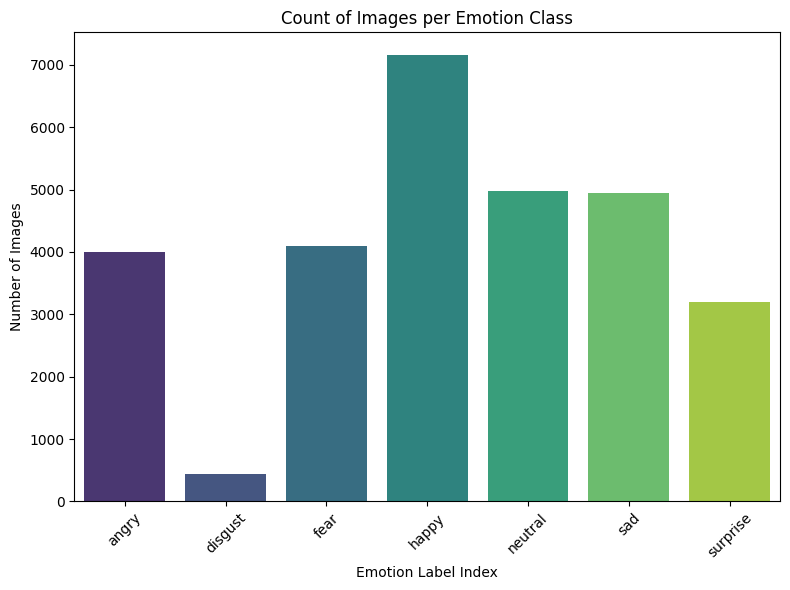

In [23]:
# Plot the distribution of images per class
import seaborn as sns
import matplotlib.pyplot as plt

# Get labels from the train generator
labels_list = train_generator.classes

# Plot count per emotion
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_list, palette='viridis')
plt.title("Count of Images per Emotion Class")
plt.xlabel("Emotion Label Index")
plt.ylabel("Number of Images")
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from collections import Counter

# Count occurrences of each class
class_counts = Counter(labels_list)

# Convert to class name if you have a mapping
class_names = list(train_generator.class_indices.keys())

# Print class counts
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} images")


angry: 3993 images
disgust: 436 images
fear: 4103 images
happy: 7164 images
neutral: 4982 images
sad: 4938 images
surprise: 3205 images


# 3.Data Augumentation

In [25]:
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
import os

# Disgust folder path
disgust_dir = '/kaggle/input/face-expression-recognition-dataset/images/train/disgust'

# List all original Disgust images
disgust_images = os.listdir(disgust_dir)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm

# Paths
disgust_dir = '/kaggle/input/face-expression-recognition-dataset/images/train/disgust'
save_dir = '/kaggle/working/disgust_augmented'  # Writable directory

# Create save folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Load original images
disgust_images = os.listdir(disgust_dir)

# Data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Target count
target_total = 4360
current_total = len(disgust_images)
images_to_generate = target_total - current_total

print(f"Generating {images_to_generate} new augmented images...")

i = 0
pbar = tqdm(total=images_to_generate)

while i < images_to_generate:
    for img_name in disgust_images:
        if i >= images_to_generate:
            break
        
        # Load and prepare image
        img_path = os.path.join(disgust_dir, img_name)
        img = load_img(img_path, color_mode='grayscale', target_size=(48, 48))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        # Generate augmented image
        aug_iter = datagen.flow(x, batch_size=1)
        aug_img = next(aug_iter)[0]
        aug_img = array_to_img(aug_img)
        
        # Save augmented image
        aug_img.save(os.path.join(save_dir, f"aug_{i}_{img_name}"))
        
        i += 1
        pbar.update(1)

pbar.close()

print("Augmentation done! New images saved in:", save_dir)


Generating 3924 new augmented images...


100%|██████████| 3924/3924 [00:09<00:00, 428.11it/s]

Augmentation done! New images saved in: /kaggle/working/disgust_augmented


    Emotion  Image Count
0  surprise         3205
1      fear         4103
2     angry         3993
3   neutral         4982
4       sad         4938
5   disgust         4360
6     happy         7164


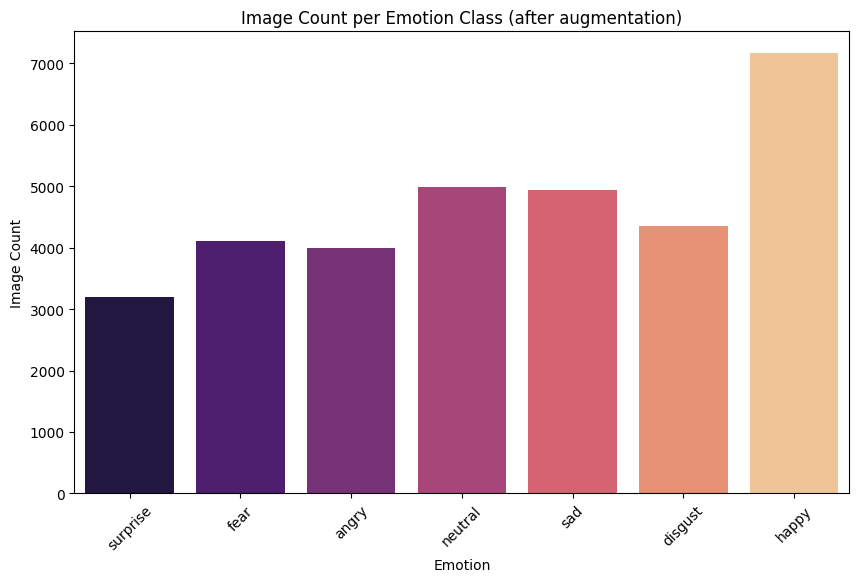

In [ ]:
import os
import pandas as pd

# train directory (original data)
train_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'

# List all emotion folders
emotion_classes = os.listdir(train_dir)
emotion_classes = [cls for cls in emotion_classes if os.path.isdir(os.path.join(train_dir, cls))]

# Count images per class
emotion_counts = {}

for emotion in emotion_classes:
    emotion_path = os.path.join(train_dir, emotion)
    count = len(os.listdir(emotion_path))
    emotion_counts[emotion] = count

# Add disgust_augmented images
augmented_disgust_dir = '/kaggle/working/disgust_augmented'
augmented_disgust_count = len(os.listdir(augmented_disgust_dir))

# Update disgust count
emotion_counts['disgust'] += augmented_disgust_count

# Display as DataFrame
emotion_df = pd.DataFrame(list(emotion_counts.items()), columns=['Emotion', 'Image Count'])
print(emotion_df)

# plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x='Emotion', y='Image Count', data=emotion_df, palette='magma')
plt.title('Image Count per Emotion Class (after augmentation)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Instead of saving to the input directory (which is read-only), we will save to a new working directory
output_dir = '/kaggle/working/augmented_dataset'
target_count=7164

# Create the output_dir if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List all class folders
class_names = os.listdir(train_dir)

for emotion_class in class_names:
    emotion_input_dir = os.path.join(train_dir, emotion_class)
    emotion_output_dir = os.path.join(output_dir, emotion_class)
    os.makedirs(emotion_output_dir, exist_ok=True)  # Create output subfolder for each emotion

    image_files = os.listdir(emotion_input_dir)
    current_count = len(image_files)
    images_needed = target_count - current_count

    print(f"\nEmotion: {emotion_class}, Current: {current_count}, Need: {images_needed}")

    if images_needed <= 0:
        continue

    i = 0
    pbar = tqdm(total=images_needed, desc=f"Augmenting {emotion_class}")
    while i < images_needed:
        img_name = np.random.choice(image_files)
        img_path = os.path.join(emotion_input_dir, img_name)
        
        img = load_img(img_path, color_mode='grayscale')
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_iter = datagen.flow(x, batch_size=1)

        aug_img = next(aug_iter)[0]
        aug_img = array_to_img(aug_img)
        
        aug_img.save(os.path.join(emotion_output_dir, f"aug_{i}.jpg"))
        
        i += 1
        pbar.update(1)

    pbar.close()

print("Augmentation complete!")



Emotion: surprise, Current: 3205, Need: 3959


Augmenting surprise: 100%|██████████| 3959/3959 [00:21<00:00, 187.52it/s]



Emotion: fear, Current: 4103, Need: 3061


Augmenting fear: 100%|██████████| 3061/3061 [00:19<00:00, 160.74it/s]



Emotion: angry, Current: 3993, Need: 3171


Augmenting angry: 100%|██████████| 3171/3171 [00:27<00:00, 115.89it/s]



Emotion: neutral, Current: 4982, Need: 2182


Augmenting neutral: 100%|██████████| 2182/2182 [00:16<00:00, 135.92it/s]



Emotion: sad, Current: 4938, Need: 2226


Augmenting sad: 100%|██████████| 2226/2226 [00:20<00:00, 109.93it/s]



Emotion: disgust, Current: 436, Need: 6728


Augmenting disgust: 100%|██████████| 6728/6728 [00:16<00:00, 406.74it/s]


Emotion: happy, Current: 7164, Need: 0
Augmentation complete!


neutral: 2182
disgust: 6728
fear: 3061
sad: 2226
happy: 0
angry: 3171
surprise: 3959


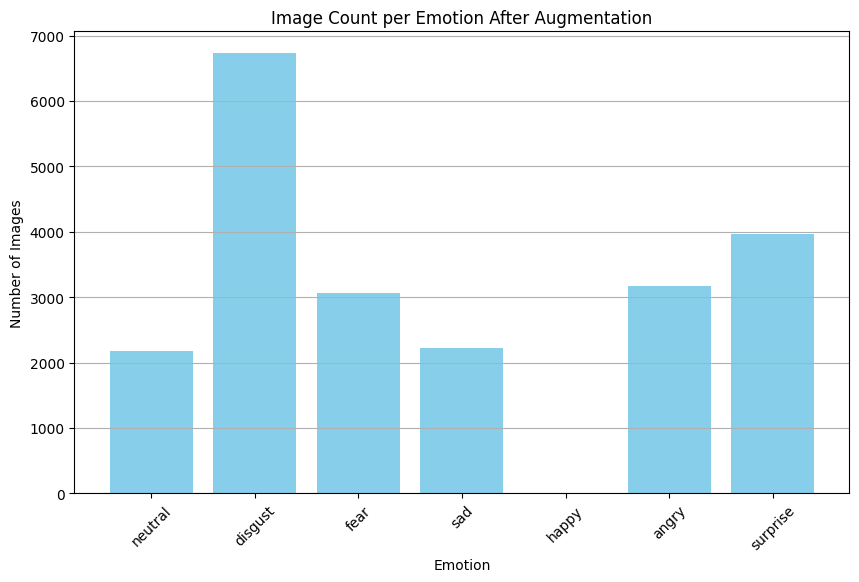

In [ ]:
import os
import matplotlib.pyplot as plt

# Path where new augmented data is saved
output_dir = '/kaggle/working/augmented_dataset'

# Get emotion class folders
emotion_classes = os.listdir(output_dir)

# Count images per emotion
emotion_counts = {}
for emotion in emotion_classes:
    emotion_path = os.path.join(output_dir, emotion)
    count = len(os.listdir(emotion_path))
    emotion_counts[emotion] = count

# Print the counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.title('Image Count per Emotion After Augmentation')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
import shutil
import os
from tqdm import tqdm

# Original data
original_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'
# Augmented data
augmented_dir = '/kaggle/working/augmented_dataset'
# Final combined data
final_combined_dir = '/kaggle/working/final_dataset'

# final_combined_dir
os.makedirs(final_combined_dir, exist_ok=True)

# List all emotion classes
emotion_classes = os.listdir(original_dir)

for emotion in emotion_classes:
    original_emotion_dir = os.path.join(original_dir, emotion)
    augmented_emotion_dir = os.path.join(augmented_dir, emotion)
    final_emotion_dir = os.path.join(final_combined_dir, emotion)

    os.makedirs(final_emotion_dir, exist_ok=True)

    print(f"\nCopying original images for {emotion}...")
    # Copy original images
    if os.path.exists(original_emotion_dir):
        for img_file in tqdm(os.listdir(original_emotion_dir)):
            src = os.path.join(original_emotion_dir, img_file)
            dst = os.path.join(final_emotion_dir, img_file)
            shutil.copy(src, dst)

    print(f"Copying augmented images for {emotion}...")
    # Copy augmented images
    if os.path.exists(augmented_emotion_dir):
        for img_file in tqdm(os.listdir(augmented_emotion_dir)):
            src = os.path.join(augmented_emotion_dir, img_file)
            dst = os.path.join(final_emotion_dir, img_file)
            shutil.copy(src, dst)

print("\n Combination complete!")



Copying original images for surprise...


100%|██████████| 3205/3205 [00:07<00:00, 424.43it/s]


Copying augmented images for surprise...


100%|██████████| 3959/3959 [00:00<00:00, 10417.15it/s]



Copying original images for fear...


100%|██████████| 4103/4103 [00:14<00:00, 288.48it/s]


Copying augmented images for fear...


100%|██████████| 3061/3061 [00:00<00:00, 10624.24it/s]



Copying original images for angry...


100%|██████████| 3993/3993 [00:14<00:00, 284.80it/s]


Copying augmented images for angry...


100%|██████████| 3171/3171 [00:00<00:00, 9748.01it/s] 



Copying original images for neutral...


100%|██████████| 4982/4982 [00:19<00:00, 250.72it/s]


Copying augmented images for neutral...


100%|██████████| 2182/2182 [00:00<00:00, 10383.78it/s]



Copying original images for sad...


100%|██████████| 4938/4938 [00:20<00:00, 242.43it/s]


Copying augmented images for sad...


100%|██████████| 2226/2226 [00:00<00:00, 10210.70it/s]



Copying original images for disgust...


100%|██████████| 436/436 [00:00<00:00, 931.58it/s] 


Copying augmented images for disgust...


100%|██████████| 6728/6728 [00:00<00:00, 10310.71it/s]



Copying original images for happy...


100%|██████████| 7164/7164 [00:56<00:00, 126.18it/s]


Copying augmented images for happy...


0it [00:00, ?it/s]


 Combination complete!


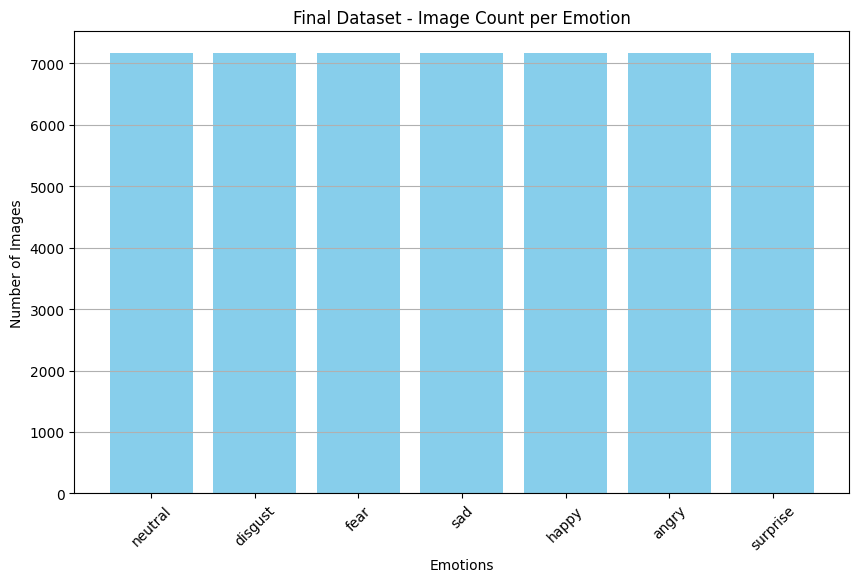

neutral: 7164 images
disgust: 7164 images
fear: 7164 images
sad: 7164 images
happy: 7164 images
angry: 7164 images
surprise: 7164 images


In [ ]:
import os
import matplotlib.pyplot as plt

# Final combined directory
final_combined_dir = '/kaggle/working/final_dataset'

# List of emotions
emotion_classes = os.listdir(final_combined_dir)

# Count of images in each emotion folder
emotion_counts = {}

for emotion in emotion_classes:
    emotion_path = os.path.join(final_combined_dir, emotion)
    num_images = len(os.listdir(emotion_path))
    emotion_counts[emotion] = num_images

# Plot
plt.figure(figsize=(10,6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Number of Images')
plt.title('Final Dataset - Image Count per Emotion')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Also printing the counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count} images")


# 3. EDA 


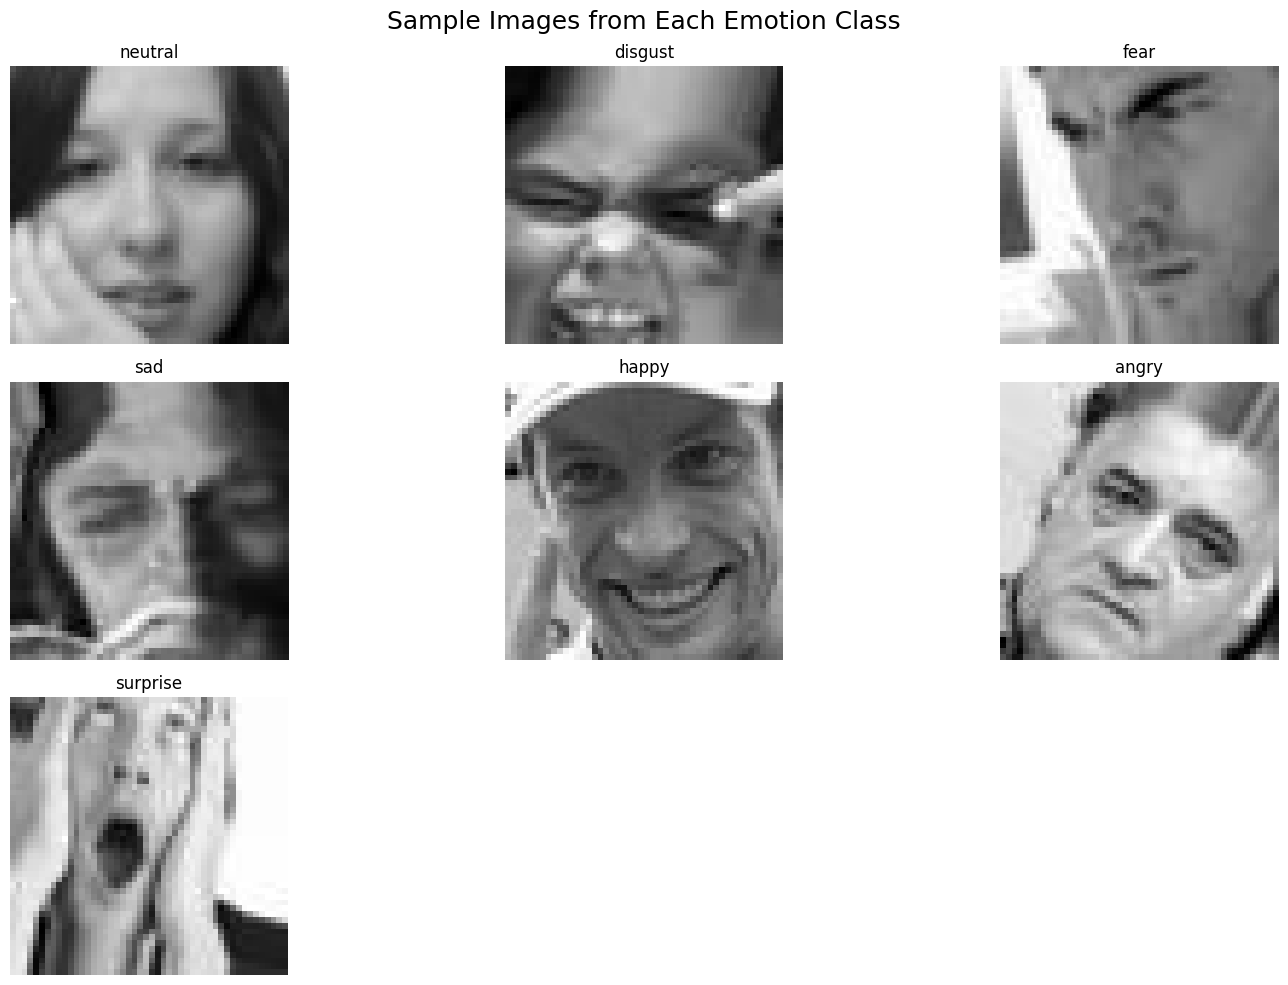

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Path to the combined dataset (both original + augmented images)
final_combined_dir = '/kaggle/working/final_dataset'  

# List of emotion class names
emotion_classes = os.listdir(final_combined_dir)

# Creating a large figure for plotting
plt.figure(figsize=(15, 10))

# Loop over each emotion class
for idx, emotion in enumerate(emotion_classes):
    emotion_path = os.path.join(final_combined_dir, emotion)  # Path to emotion folder
    
    # Randomly picking one image from the emotion folder
    img_name = random.choice(os.listdir(emotion_path))
    img_path = os.path.join(emotion_path, img_name)
    
    # Loading the image in grayscale mode
    img = image.load_img(img_path, color_mode='grayscale')
    img = image.img_to_array(img)
    
    # Creating a subplot
    plt.subplot(3, 3, idx+1)
    plt.imshow(img.squeeze(), cmap='gray')  # Display the image
    plt.title(emotion)                      # Title with emotion name
    plt.axis('off')                         # Turn off axis (clean look)

# Adding title on top
plt.suptitle('Sample Images from Each Emotion Class', fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image

# List to store image sizes
sizes = []

# Loop over each emotion folder
for emotion in emotion_classes:
    emotion_path = os.path.join(final_combined_dir, emotion)
    
    # Picking 50 random images to check
    sample_images = random.sample(os.listdir(emotion_path), min(50, len(os.listdir(emotion_path))))
    
    for img_name in sample_images:
        img_path = os.path.join(emotion_path, img_name)
        
        # Open image and get its size
        with Image.open(img_path) as img:
            sizes.append(img.size)

# Display unique image sizes
unique_sizes = set(sizes)
print(f"Unique image sizes in dataset: {unique_sizes}")


Unique image sizes in dataset: {(48, 48)}


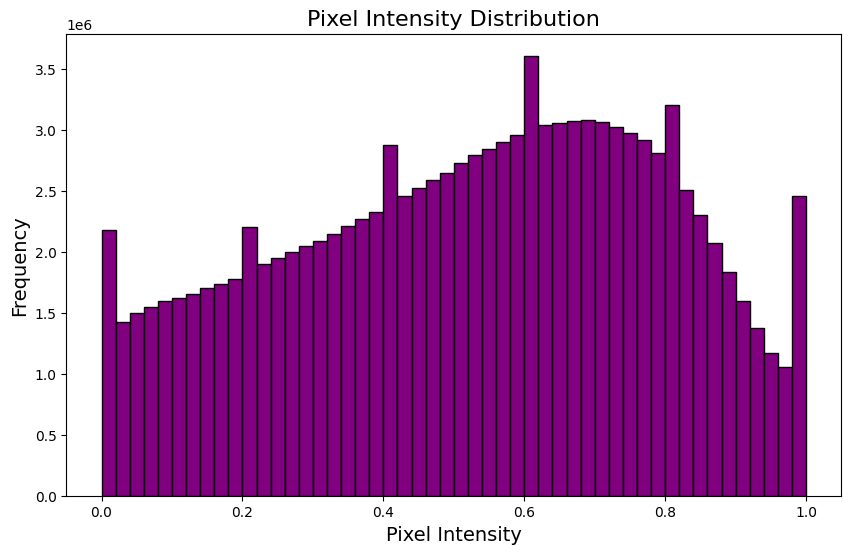

In [44]:
import numpy as np

# Function to gather pixel values across dataset
def get_pixel_values(directory):
    pixel_values = []
    
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        images = os.listdir(emotion_path)
        
        for img_name in images:
            img_path = os.path.join(emotion_path, img_name)
            img = load_img(img_path, color_mode='grayscale')
            img_array = img_to_array(img)/ 255.0
            pixel_values.extend(img_array.flatten())
    
    return np.array(pixel_values)

# Get all pixel values
pixel_values = get_pixel_values(final_combined_dir)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(pixel_values, bins=50, color='purple', edgecolor='black')
plt.title('Pixel Intensity Distribution', fontsize=16)
plt.xlabel('Pixel Intensity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


# 4. Splitting Data 

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

# Training generator
train_generator = datagen.flow_from_directory(
    '/kaggle/working/final_dataset', 
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    '/kaggle/working/final_dataset', 
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 40124 images belonging to 7 classes.
Found 10024 images belonging to 7 classes.


# 5.Model Building and Training

In [56]:
#Using custom CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build the model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(7, activation='softmax')  # 7 classes
])

# Compile the model
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,858,839 (7.09 MB)

 Trainable params: 619,463 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,238,928 (4.73 MB)

In [57]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=1, 
    min_lr=1e-6
)

# Train
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop,reduce_lr]
)

Epoch 1/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.2361 - loss: 2.0410 - val_accuracy: 0.3310 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 2/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.3506 - loss: 1.6521 - val_accuracy: 0.4225 - val_loss: 1.5969 - learning_rate: 0.0010
Epoch 3/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4099 - loss: 1.5201 - val_accuracy: 0.4457 - val_loss: 1.5111 - learning_rate: 0.0010
Epoch 4/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.4428 - loss: 1.4260 - val_accuracy: 0.4384 - val_loss: 1.5812 - learning_rate: 0.0010
Epoch 5/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.4686 - loss: 1.3643 - val_accuracy: 0.4928 - val_loss: 1.3958 - learning_rate: 0.0010
Epoch 6/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5024 - loss: 1.2883 - val_accuracy: 0.4992 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 7/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accura

In [62]:
model1.save('model1_trained.h5')

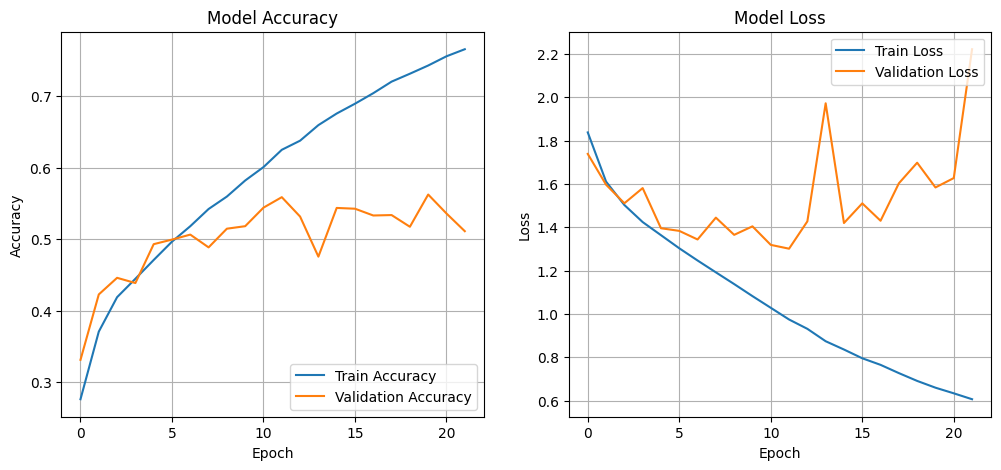

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


# Using Transfer Learning

In [ ]:
# Step 1: Import
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Step 2: Load Pre-trained Model (without top layers)
base_model = MobileNetV2(
    weights='imagenet',      # Load pre-trained ImageNet weights
    include_top=False,       # Not including the final Dense layer
    input_shape=(48, 48, 3)  # Our images are 48x48 (and 3 channels)
)

# Step 3: Freezing the base model
base_model.trainable = False

# Step 4: Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 emotion classes

# Step 5: Combine
model_tl = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Compile
model_tl.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()
model_tl.build((None, 48, 48, 3))

<ipython-input-69-73f438957df0>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 24, 24, 32)     │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 24, 24, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 24, 24, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 24, 24, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 24, 24, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 24, 24, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 24, 24, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 24, 24, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 24, 24, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 24, 24, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 24, 24, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 25, 25, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 12, 12, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [72]:
# Callbacks (EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7, 
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Train the model
history_tl = model_tl.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 69s 48ms/step - accuracy: 0.2352 - loss: 1.9200 - val_accuracy: 0.2586 - val_loss: 1.8941 - learning_rate: 0.0010
Epoch 2/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.2893 - loss: 1.7953 - val_accuracy: 0.2608 - val_loss: 1.9015 - learning_rate: 0.0010
Epoch 3/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.2944 - loss: 1.7772 - val_accuracy: 0.2653 - val_loss: 1.8660 - learning_rate: 0.0010
Epoch 4/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.2998 - loss: 1.7719 - val_accuracy: 0.2922 - val_loss: 1.8421 - learning_rate: 0.0010
Epoch 5/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.3031 - loss: 1.7613 - val_accuracy: 0.2783 - val_loss: 1.8365 - learning_rate: 0.0010
Epoch 6/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.3051 - loss: 1.7543 - val_accuracy: 0.2704 - val_loss: 1.8702 - learning_rate: 0.0010
Epoch 7/30
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accura

KeyboardInterrupt: 

# Resizing to 224*224 to use for Resnet50/efficientnet

In [ ]:
import os
from PIL import Image
import shutil

# Set paths
original_dir = '/kaggle/working/final_dataset'  # Path to the original dataset
resized_dir = '/kaggle/working/resized'  # Path to save resized images

# Create resized directory 
if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

# Define the target size
target_size = (224, 224)

# Function to resize images and save them to a new directory
def resize_images():
    for root, dirs, files in os.walk(original_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                # Full path of original image
                original_image_path = os.path.join(root, file)

                # Open image using PIL
                img = Image.open(original_image_path)

                # Resize the image
                img_resized = img.resize(target_size)

                # Get the relative path of the image from the original directory
                relative_path = os.path.relpath(root, original_dir)

                # Create directories in the resized folder
                new_dir = os.path.join(resized_dir, relative_path)
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir)

                # Save the resized image
                img_resized.save(os.path.join(new_dir, file))

# Run the resize function
resize_images()

print("Image resizing completed and saved to resized directory.")


Image resizing completed and saved to resized directory.


# trying with 48*48 first

In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

# Training generator
train_generator = datagen.flow_from_directory(
    '/kaggle/working/final_dataset', 
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    '/kaggle/working/final_dataset', 
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 40124 images belonging to 7 classes.
Found 10024 images belonging to 7 classes.


In [105]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define input shape for grayscale images
input_shape = (48, 48, 1)

# Input layer
inputs = Input(shape=input_shape)

# Convert grayscale (1 channel) to RGB (3 channels)
x = Conv2D(3, (3,3), padding='same')(inputs)

# Now feed into ResNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
x = base_model(x, training=False)

# Add custom layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(7, activation='softmax')(x)  # 7 classes for emotion

# Build the model
modelv = Model(inputs=inputs, outputs=outputs)

# Compile
modelv.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelv.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,640,421 (94.00 MB)

 Trainable params: 24,587,301 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = modelv.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50
)


Epoch 1/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 125s 63ms/step - accuracy: 0.2622 - loss: 2.3228 - val_accuracy: 0.3561 - val_loss: 1.6930
Epoch 2/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.4697 - loss: 1.3959 - val_accuracy: 0.5070 - val_loss: 1.3530
Epoch 3/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.5483 - loss: 1.1918 - val_accuracy: 0.5263 - val_loss: 1.3074
Epoch 4/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.6123 - loss: 1.0366 - val_accuracy: 0.5900 - val_loss: 1.1434
Epoch 5/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.6703 - loss: 0.8879 - val_accuracy: 0.5628 - val_loss: 1.2713
Epoch 6/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7315 - loss: 0.7329 - val_accuracy: 0.5921 - val_loss: 1.1550
Epoch 7/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7891 - loss: 0.5836 - val_accuracy: 0.6002 - val_loss: 1.2399
Epoch 8/50
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.8418 

In [49]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model Training
history = modelv.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - accuracy: 0.2437 - loss: 2.3979 - val_accuracy: 0.3159 - val_loss: 1.9674 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 43s 94ms/step - accuracy: 0.3807 - loss: 1.6473 - val_accuracy: 0.3943 - val_loss: 1.5075 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.4343 - loss: 1.4696 - val_accuracy: 0.4580 - val_loss: 1.4273 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 65s 142ms/step - accuracy: 0.4660 - loss: 1.4073 - val_accuracy: 0.3956 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.4856 - loss: 1.3490 - val_accuracy: 0.5074 - val_loss: 1.2922 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.4974 - loss: 1.3169 - val_accuracy: 0.5028 - val_loss: 1.3123 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 44s 96ms/step - accuracy: 0.5033 - loss: 1

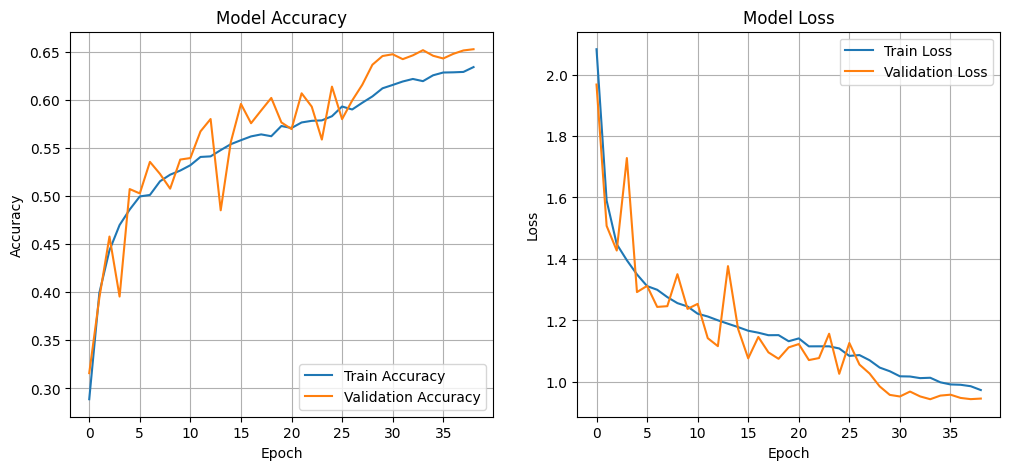

In [54]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


In [55]:
modelv.save('facial_emotion_detection_model.h5')